In [2]:
import numpy as np
import pandas as pd
import datetime
import functools

In [3]:
targets = [_.strip() for _ in open('validation/targets').readlines()]

In [4]:
def read_ccsd_result(target):
    lines = open('validation/CCSD/%s/run.log' % target).readlines()
    for line in lines:
        if ' ***FINAL HARTREE-FOCK ENERGY' in line:
            E_HF = float(line.strip().split()[-2])
        if 'MP2 energy' in line:
            E_MP2 = float(line.strip().split()[-1])
        if 'Total CCSD energy' in line:
            E_CCSD = float(line.strip().split()[-1])

    times = [datetime.datetime.strptime(_[26:45], '%Y-%m-%d %H:%M:%S') for _ in lines if '************************ ' in _]
    ccsd_time = (times[-1]-times[0]).seconds/60
    mp2_time = (times[-2]-times[0]).seconds/60
    hf_time = (times[-3]-times[0]).seconds/60
    return {'target': target, 'hf_time': hf_time, 'mp2_time': mp2_time, 'ccsd_time': ccsd_time, 'HF_T': E_HF, 'MP2_T': E_MP2, 'CCSD_T': E_CCSD}

In [5]:
def read_results(fn):
    ccsd_result = []
    for target in targets:
        try:
            r = fn(target)
        except:
            continue
        ccsd_result.append(r)
    return pd.DataFrame(ccsd_result)
ccsd_df = read_results(read_ccsd_result)

In [6]:
ccsd_df.sum()

CCSD_T      -7.036894e+05
HF_T        -7.020499e+05
MP2_T       -7.036807e+05
ccsd_time    1.514472e+04
hf_time      2.470150e+03
mp2_time     7.492833e+03
target                inf
dtype: float64

In [7]:
def read_pbe_result(target):
    lines = open('validation/PBE/%s/run.log' % target).readlines()
    for line in lines:
        if 'ENERGY| Total FORCE_EVAL' in line:
            epbe = float(line.strip().split()[-1])
        if 'CP2K                                 1' in line:
            pbetime = float(line.strip().split()[-1])/60
    return {'target': target, 'PBE_T': epbe, 'pbe_time': pbetime}
            
pbe_df = read_results(read_pbe_result)
-9.772560266932857

-9.772560266932857

In [8]:
pm6_df = pd.read_csv('validation/PM6.results', sep='\s+', names='target a b c PM6_T'.split())['target PM6_T'.split()]
pm6_df['PM6_T'] *= 0.0367493

In [9]:
uff_df = pd.read_csv('validation/UFF.results', sep=' ', names='target a b c UFF_T d'.split())['target UFF_T'.split()]
uff_df['UFF_T'] /= 2625.50

In [10]:
apdft_df = pd.read_csv('validation/APDFT.csv')['target APDFT0_T APDFT1_T'.split()]
combined = pd.merge(pd.merge(pd.merge(pd.merge(pbe_df, ccsd_df), uff_df), pm6_df), apdft_df)

In [11]:
@functools.lru_cache(200)
def get_atomisation_offset(method, bnpairs):
    atom = pd.read_csv('validation/atom', sep=' ')
    q = atom.query('method == @method').iloc[0]
    return (q.B + q.N)*bnpairs + 2*q.C * (10-bnpairs)
get_atomisation_offset('PBE', 2)

-109.62130618445514

In [12]:
def decorate(row):
    row['bnpairs'] = len([_ for _ in row['target'] if _ == '5'])
    for method in 'PBE CCSD HF MP2 UFF PM6 APDFT0 APDFT1'.split():
        row['%s_A' % method] = row['%s_T' % method] - get_atomisation_offset(method, row['bnpairs'])
    return row
combined = combined.apply(decorate, axis=1)

In [13]:
import matplotlib.pyplot as plt

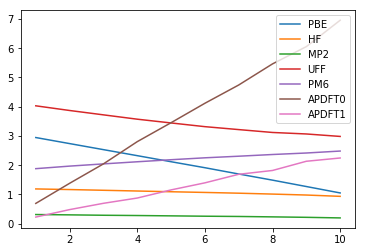

In [14]:
for method in 'PBE HF MP2 UFF PM6 APDFT0 APDFT1'.split():
    combined['deltaE'] = np.abs(combined.CCSD_A - combined['%s_A' % method])
    q = combined.groupby('bnpairs').mean().reset_index()
    plt.plot(q.bnpairs, q.deltaE, label=method)
plt.legend()

In [15]:
total = 3100000
timings = {}
timings['PM6'] = 221.86/len(pm6_df)*total/60/60/24
timings['UFF'] = 140/len(uff_df)*total/60/60/24
timings['APDFT'] = 4.69/len(apdft_df)*total/60/60/24 + 302894/len(ccsd_df)*3/60/24
timings['PBE'] = 8245.915/len(pbe_df)*total/60/24
timings['CCSD'] = 302894/len(ccsd_df)*total/60/24
timings['HF'] = 49403/len(ccsd_df)*total/60/24
timings['MP2'] = 149857/len(ccsd_df)*total/60/24
timings

{'PM6': 8.795861469204011,
 'UFF': 5.550439942705136,
 'APDFT': 0.8680163286834256,
 'PBE': 19767.953863523882,
 'CCSD': 721309.150688299,
 'HF': 117647.87672074728,
 'MP2': 356868.16310226155}

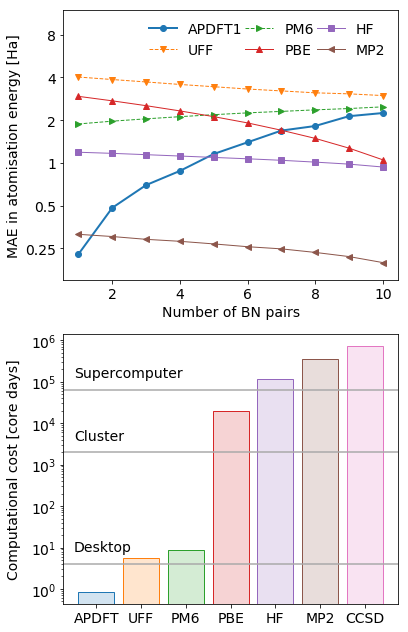

In [20]:
plt.rcParams.update({'font.size': 14})
methods = 'APDFT UFF PM6 PBE HF MP2 CCSD'.split()
f, ax = plt.subplots(2, 1, figsize=(6, 6))

for idx, omethod in enumerate(methods):
    if omethod == 'CCSD':
        continue
    if omethod == 'APDFT':
        method = 'APDFT1'
    else:
        method = omethod
    combined['deltaE'] = np.abs(combined.CCSD_A - combined['%s_A' % method])
    q = combined.groupby('bnpairs').mean().reset_index()
    markers = 'o v > ^ s <'.split()
    if method in 'PM6 UFF'.split():
        kind = markers[idx] + '--'
    else:
        kind = markers[idx] + '-'
    ax[0].plot(q.bnpairs, q.deltaE, kind, lw=(method == 'APDFT1')+1, label=method)

ax[0].semilogy()
ax[0].legend( ncol=3, frameon=False,columnspacing=0.2)
ticks = (0.25, 0.5, 1, 2, 4, 8,)
ax[0].set_yticks(ticks)
ax[0].tick_params(which='minor', length=0)
ax[0].set_yticklabels(ticks)
ax[0].set_ylim(0.15, 12)

ax[0].set_xlabel('Number of BN pairs')
ax[0].set_ylabel('MAE in atomisation energy [Ha]')
xs = range(len(methods))
ys = [timings[_] for _ in methods]
ax[1].bar(xs, ys, color=['C%d' % _ for _ in xs], alpha=0.2)
ax[1].bar(xs, ys, edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax[1].semilogy()
ax[1].set_xticks(xs)
ax[1].set_xticklabels(methods)
ax[1].axhline(4, color='darkgrey')
ax[1].text(-.5, 8, 'Desktop')
ax[1].axhline(2000, color='darkgrey')
ax[1].text(-.5, 4000, 'Cluster')
ax[1].axhline(5320*12, color='darkgrey')
ax[1].text(-.5, 5320*12*2, 'Supercomputer')
ax[1].set_ylabel('Computational cost [core days]')
plt.subplots_adjust(top=1.5)
f.align_ylabels(ax)
plt.savefig('apdft-c20.pdf', bbox_inches='tight')

In [17]:
# higher order data

In [18]:
trimers = '''NNO&-243.416&21.0&20.8&-1.0&-0.4&-0.5&9.8&62.0&-262.3&120.1&210.2\\
NON&-241.690&-306.9&212.5&-47.8&-12.3&17.0&-47.3&104.3&-288.4&164.0&275.4\\
COO&-244.689&324.9&323.1&-25.6&2.9&41.3&-38.8&35.0&-209.6&151.6&244.9\\
BOF&-253.747&2280.1&714.6&47.2&20.0&-275.0&-&12.4&-145.7&114.8&179.7\\
OBF&-253.264&21.3&21.5&-0.3&-1.0&-0.5&-9.4&38.9&-169.6&17.5&62.0\\
NCF&-248.728&6.6&6.6&2.5&2.5&-0.6&0.8&38.8&-198.3&79.6&142.9\\
CCNe&-255.981&156.5&156.5&88.3&88.5&-110.8&-121.8&20.7&-127.9&121.9&182.1'''
benzenes = '''BNCCCC&-436.447&30.7&30.7&-2.3&-2.2&-2.6&-4.4&70.9&-361.1&209.2&254.6\\
BCNCCC&-436.542&31.6&31.6&-1.5&-1.3&3.4&-6.2&76.7&-371.0&214.3&263.7\\
BCCNCC&-436.581&35.4&35.4&-3.1&-3.1&0.9&-0.3&71.6&-362.6&212.1&258.7\\
BNCBNC&-438.247&59.1&59.1&-2.1&-2.0&3.0&2.9&77.1&-362.9&215.9&267.3\\
BNBNCC&-438.258&58.2&58.2&-9.9&-10.0&7.2&8.6&65.1&-334.9&208.1&249.4\\
BNBCNC&-438.281&57.2&59.8&-3.4&-2.3&1.5&-16.7&75.3&-358.0&214.8&264.5\\
BNCBCN&-438.286&62.7&60.1&-2.9&-3.9&-2.7&13.5&69.6&-351.5&214.8&263.3\\
BNCNBC&-438.362&33.1&33.1&-17.1&-17.1&34.8&33.4&68.1&-348.6&214.6&262.1\\
BNCCNB&-438.401&83.7&88.5&-27.1&-21.4&-4.3&-6.4&64.6&-351.1&212.9&260.6\\
BNNBCC&-438.413&96.6&91.8&-23.8&-29.2&-9.9&-13.6&64.8&-347.3&212.7&259.7\\
BNCNCB&-438.542&62.0&64.2&-29.8&-24.3&23.9&25.6&71.5&-361.9&220.2&272.7\\
BNNCBC&-438.553&72.6&70.4&-23.5&-29.0&17.0&14.5&70.3&-358.0&220.1&272.0\\
BNNCCB&-438.673&99.3&99.3&-41.3&-41.4&24.5&29.5&64.5&-351.8&220.7&271.1\\
BCNNCB&-438.785&82.5&82.5&-28.3&-28.3&20.2&20.1&76.6&-370.7&227.6&284.4\\
NBNBNB&-439.998&72.2&72.2&-25.4&-25.4&46.1&46.0&62.1&-304.8&204.4&238.9\\
BNBNNB&-440.300&141.5&141.5&-61.5&-61.5&-1.4&-0.8&58.6&-326.2&214.2&259.2\\
BNNNBB&-440.806&133.6&133.6&-2.0&-2.0&162.2&163.6&57.2&-347.4&228.8&285.1'''

In [19]:
def parse_latex_table(string, columns):
    rows = []
    for line in string.split("\n"):
        row = {}
        parts = line.strip().strip('\\').split('&')
        for colname, val in zip(columns, parts):
            try:
                val = abs(float(val))
            except:
                pass
            if val == '-':
                val = np.nan
            row[colname] = val
        rows.append(row)
    return pd.DataFrame(rows)

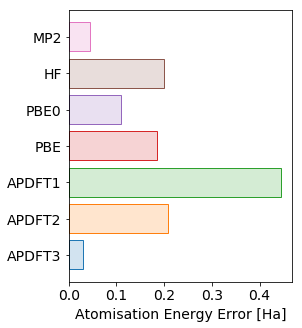

In [336]:
q = parse_latex_table(trimers, 'mol ccsd o1 o2 o3 o4 o5 o6 mp2 hf pbe0 pbe'.split()).mean()
f, ax = plt.subplots(1, 1, figsize=(4, 5))
labels = {'mp2': 'MP2', 'hf': 'HF', 'pbe': 'PBE', 'pbe0': 'PBE0', 'o1': 'APDFT1', 'o2': 'APDFT2', 'o3': 'APDFT3'}
methods = 'mp2 hf pbe0 pbe o1 o2 o3'.split()[::-1]
xs = range(len(methods))
ys = [q.loc[_] for _ in methods]
plt.barh(xs, np.array(ys)/1000, color=['C%d' % _ for _ in xs], alpha=0.2)
plt.barh(xs, np.array(ys)/1000, edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax.set_yticks(xs)
ax.set_yticklabels([labels[_] for _ in methods])
plt.xlabel('Atomisation Energy Error [Ha]')
plt.savefig('trimer.pdf', bbox_inches='tight')

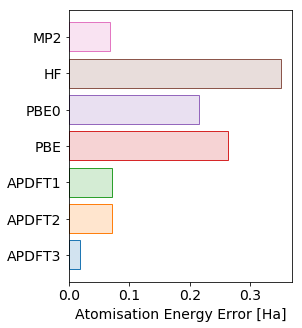

In [338]:
q = parse_latex_table(benzenes, 'mol ccsd o1 o2 o3 o4 o5 o6 mp2 hf pbe0 pbe'.split()).mean()
f, ax = plt.subplots(1, 1, figsize=(4, 5))
labels = {'mp2': 'MP2', 'hf': 'HF', 'pbe': 'PBE', 'pbe0': 'PBE0', 'o1': 'APDFT1', 'o2': 'APDFT2', 'o3': 'APDFT3'}
methods = 'mp2 hf pbe0 pbe o1 o2 o3'.split()[::-1]
xs = range(len(methods))
ys = [q.loc[_] for _ in methods]
plt.barh(xs, np.array(ys)/1000, color=['C%d' % _ for _ in xs], alpha=0.2)
plt.barh(xs, np.array(ys)/1000, edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax.set_yticks(xs)
ax.set_yticklabels([labels[_] for _ in methods])
plt.xlabel('Atomisation Energy Error [Ha]')
plt.savefig('benzenederiv.pdf', bbox_inches='tight')

In [342]:
', '.join(parse_latex_table(benzenes, 'mol ccsd o1 o2 o3 o4 o5 o6 mp2 hf pbe0 pbe'.split()).mol.values)

'BNCCCC, BCNCCC, BCCNCC, BNCBNC, BNBNCC, BNBCNC, BNCBCN, BNCNBC, BNCCNB, BNNBCC, BNCNCB, BNNCBC, BNNCCB, BCNNCB, NBNBNB, BNBNNB, BNNNBB'

[0, 1, 2, 3, 4, 5, 6] (-0.12, -0.41, -0.45, 0.01, 0.49, 0.47, -0.92)


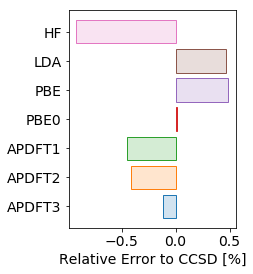

In [367]:
methods = 'HF LDA PBE PBE0 APDFT1 APDFT2 APDFT3'.split()[::-1]
f, ax = plt.subplots(1, 1, figsize=(3, 4))
ys = (-0.92, 0.47, 0.49, 0.01, -0.45, -0.41, -0.12,)[::-1]
xs = list(range(len(methods)))
print (xs, ys)
plt.barh(xs, np.array(ys), color=['C%d' % _ for _ in xs], alpha=0.2)
plt.barh(xs, np.array(ys), edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax.set_yticks(xs)
ax.set_yticklabels(methods)
plt.xlabel('Relative Error to CCSD [%]')
plt.savefig('dipoleerror.pdf', bbox_inches='tight')

[0, 1, 2, 3, 4, 5, 6] (-0.08, -0.4, -1.77, 0.05, 0.46, 0.37, -0.5)


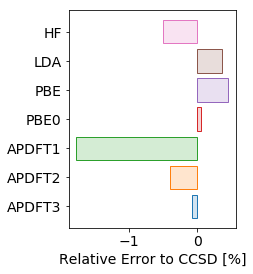

In [368]:
methods = 'HF LDA PBE PBE0 APDFT1 APDFT2 APDFT3'.split()[::-1]
f, ax = plt.subplots(1, 1, figsize=(3, 4))
ys = (-0.5, 0.37, 0.46, 0.05, -1.77, -0.4, -0.08)[::-1]
xs = list(range(len(methods)))
print (xs, ys)
plt.barh(xs, np.array(ys), color=['C%d' % _ for _ in xs], alpha=0.2)
plt.barh(xs, np.array(ys), edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax.set_yticks(xs)
ax.set_yticklabels(methods)
plt.xlabel('Relative Error to CCSD [%]')
plt.savefig('quadrupoleerror.pdf', bbox_inches='tight')

[0, 1, 2, 3, 4, 5, 6] (-0.04, -0.09, 0.99, -1.03, -1.02, -0.53, -1.33)


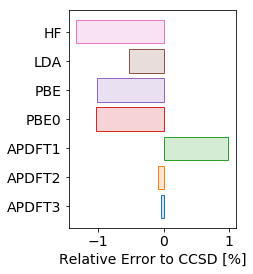

In [369]:
methods = 'HF LDA PBE PBE0 APDFT1 APDFT2 APDFT3'.split()[::-1]
f, ax = plt.subplots(1, 1, figsize=(3, 4))
ys = (-1.33, -0.53, -1.02, -1.03, 0.99, -0.09, -0.04)[::-1]
xs = list(range(len(methods)))
print (xs, ys)
plt.barh(xs, np.array(ys), color=['C%d' % _ for _ in xs], alpha=0.2)
plt.barh(xs, np.array(ys), edgecolor=['C%d' % _ for _ in xs], facecolor='none')
ax.set_yticks(xs)
ax.set_yticklabels(methods)
plt.xlabel('Relative Error to CCSD [%]')

plt.savefig('forceerror.pdf', bbox_inches='tight')